# Poisson Regression: Shark Attacks

We will build a Poisson Regression model for shark attacks using the data from [Analyzing Categorical Data](https://doi.org/10.1007/978-0-387-21727-7) by J. S. Simonoff (2003).

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pystan
import arviz as az

In [2]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (16, 8)

Read the data.

In [3]:
sharks = pd.read_csv('data/florida-shark.csv', comment='#')
sharks.head()

,year,population,attacks,fatalities
0,1946,2473000,0,0
1,1947,2539000,1,1
2,1948,2578000,0,0
3,1949,2668000,0,0
4,1950,2771305,1,0


Add in a rate column, which is the number of attacks per 100 000 people.

In [4]:
sharks['rate'] = sharks.attacks / sharks.population * 100000

## Exploratory Analysis

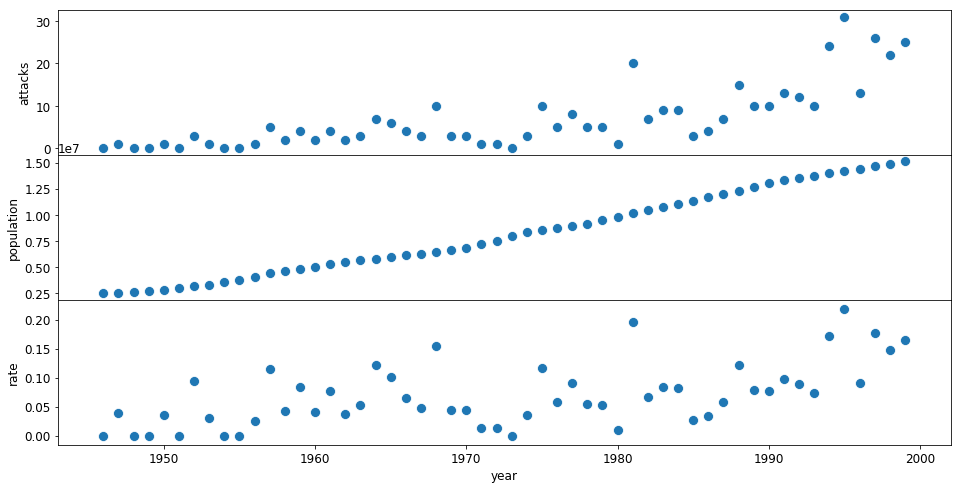

In [5]:
fig, ax = plt.subplots(nrows=3, figsize=(16, 8), sharex=True)
sns.scatterplot(x="year", y="attacks", s=100, data=sharks, ax=ax[0])
sns.scatterplot(x="year", y="population", s=100, data=sharks, ax=ax[1])
sns.scatterplot(x="year", y="rate", s=100, data=sharks, ax=ax[2])
fig.subplots_adjust(hspace=0);

The total number of shark attacks is escalating as a function of both time and population. Since the population is increasing with time, the *exposure* is also increasing. This needs to be factored into the model.

## Poisson Regression

In [6]:
data_sharks = {
    'N': sharks.shape[0],
    'population': sharks.population,
    'year': sharks.year,
    'attacks': sharks.attacks,
}

As far as priors are concerned:
    
- I have no idea at all about $\alpha$ but
- I am guessing that $\beta$ might be around 1% per year.

In [7]:
stan_sharks_poisson = """
data {
    int<lower=0> N;
    int<lower=0> attacks[N];
    real         year[N];
    int<lower=0> population[N];
}
parameters {
    real         alpha;
    real         beta;
}
model {
    beta ~ normal(0.01, 0.01);
    for (n in 1:N)
        attacks[n] ~ poisson_log(log(population[n]) + alpha + beta * year[n]);
}
generated quantities {
    real attacks_pred[N];
    for (n in 1:N)
        attacks_pred[n] = poisson_log_rng(log(population[n]) + alpha + beta * year[n]);
}
"""

In [8]:
model_sharks_poisson = pystan.StanModel(model_code=stan_sharks_poisson);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3fc05bfcc8dc521ef9a474ab4df057e0 NOW.


In [9]:
fit = model_sharks_poisson.sampling(data=data_sharks, control={'max_treedepth': 15,})

In [10]:
print(fit.stansummary(pars=['alpha', 'beta']))

Inference for Stan model: anon_model_3fc05bfcc8dc521ef9a474ab4df057e0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha -70.01    0.39   7.72 -85.27 -75.01 -69.84  -64.9 -55.05    383   1.01
beta    0.03  2.0e-4 3.9e-3   0.02   0.03   0.03   0.03   0.04    383   1.01

Samples were drawn using NUTS at Fri Oct 19 09:12:36 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


These results suggest that the rate of shark attacks is increasing at 3% per year, where the increase in population has been controlled for.

### Parameter Distribution

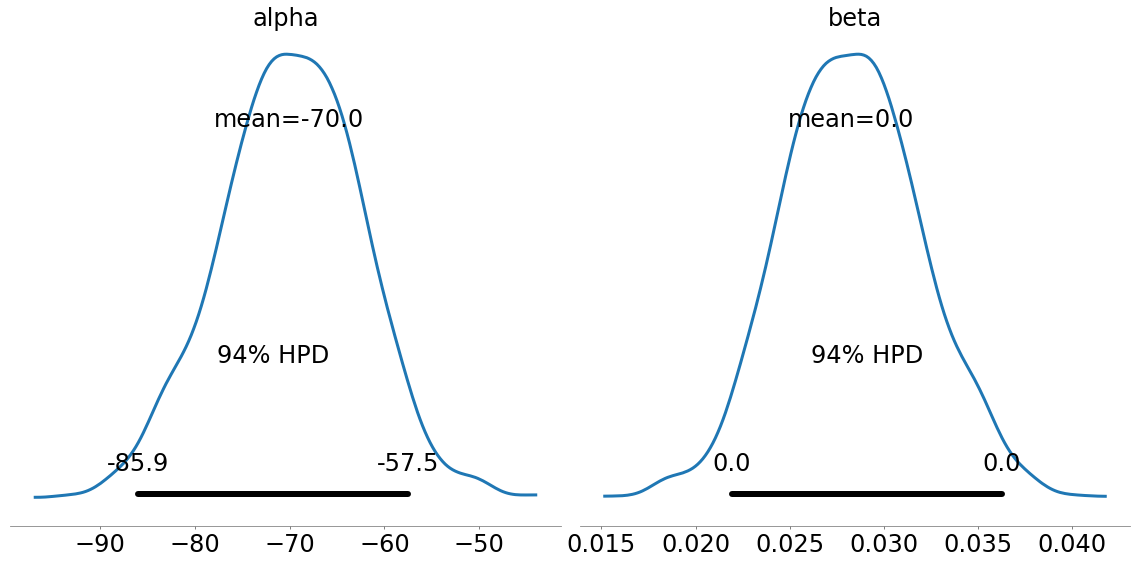

In [11]:
az.plot_posterior(fit, var_names=['alpha', "beta"], figsize = (16, 8));

/opt/conda/lib/python3.6/site-packages/arviz/plots/kdeplot.py:281: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


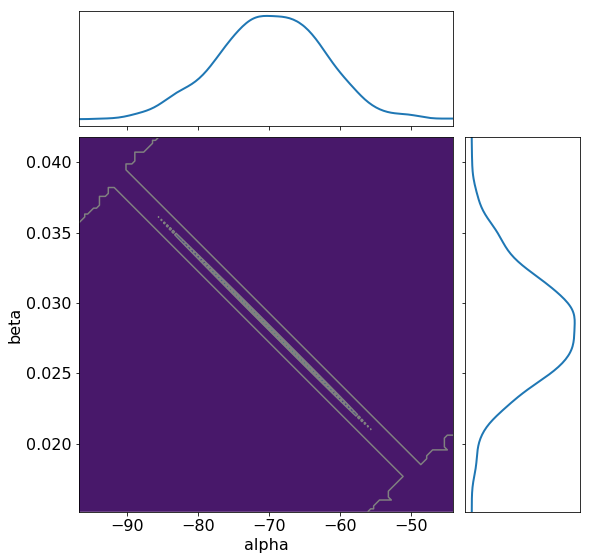

In [12]:
az.plot_joint(fit, var_names=['alpha', 'beta'], kind="kde", figsize=(8, 8));

That's a very strong correlation between `alpha` and `beta`! But this is analogous to the correlation between slope and intercept with a Linear Regression model.

### Simulated Predictions

In [13]:
attacks_pred = fit.extract()['attacks_pred']

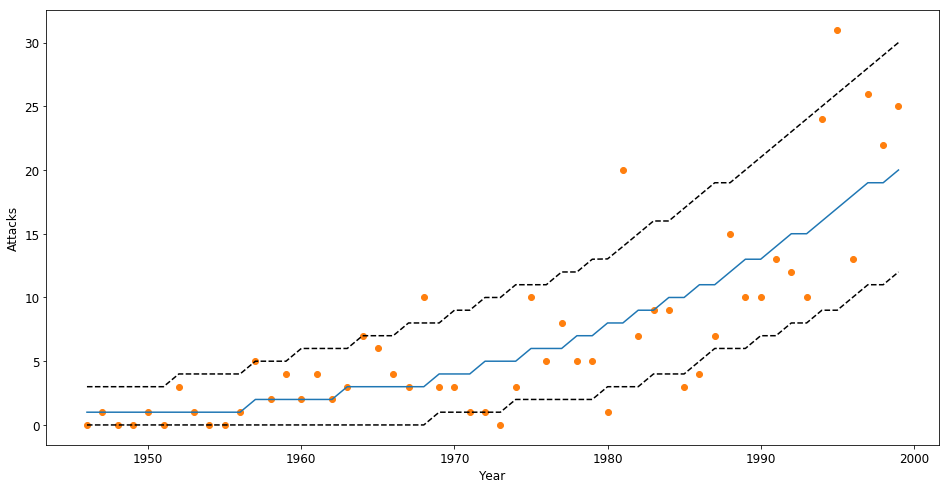

In [14]:
plt.scatter(sharks.year, sharks.attacks, color='#ff7f0e')
plt.plot(sharks.year, np.median(attacks_pred, axis=0))
plt.plot(sharks.year, np.percentile(attacks_pred,  2.5, axis=0), linestyle='dashed', color='black')
plt.plot(sharks.year, np.percentile(attacks_pred, 97.5, axis=0), linestyle='dashed', color='black')
plt.xlabel('Year')
plt.ylabel('Attacks')
plt.show();

Seems pretty good, but it looks like we are not capturing all of the variance in the data. Perhaps an overdispersed model would work better?

## Negative Binomial Regression

In [15]:
stan_sharks_neg_binom = """
data {
    int<lower=0> N;
    int<lower=0> attacks[N];
    real         year[N];
    int<lower=0> population[N];
}
parameters {
    real         alpha;
    real         beta;
    real         reciprocal_phi;
}
transformed parameters {
    real<lower=0> phi;
    phi = 1 / reciprocal_phi;
}
model {
    beta ~ normal(0.01, 0.01);
    reciprocal_phi ~ cauchy(0, 10);
    for (n in 1:N)
        attacks[n] ~ neg_binomial_2_log(log(population[n]) + alpha + beta * year[n], phi);
}
generated quantities {
    real attacks_pred[N];
    for (n in 1:N) 
        attacks_pred[n] = neg_binomial_2_log_rng(log(population[n]) + alpha + beta * year[n], phi);
}
"""

The overdispersion parameter, $\phi^{-1}$, indicates how the variance of the Negative Binomial is inflated relative to the Poisson. In the limit of large $\phi$ this becomes equivalent to the Poisson model.

**Note:** There seems to be a known problem with models like the above. Apparently something breaks in the generated quantities block during the warmup phase of the simulation. Would be great to understand the problem and also find a way around it.